<h2 align=center> Fine-Tune BERT for Text Classification with TensorFlow</h2>

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 1: BERT Classification Model</p>
</div>

In this [project](https://www.coursera.org/projects/fine-tune-bert-tensorflow/), you will learn how to fine-tune a BERT model for text classification using TensorFlow and TF-Hub.

The pretrained BERT model used in this project is [available](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2) on [TensorFlow Hub](https://tfhub.dev/).

### Learning Objectives

By the time you complete this project, you will be able to:

- Build TensorFlow Input Pipelines for Text Data with the [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) API
- Tokenize and Preprocess Text for BERT
- Fine-tune BERT for text classification with TensorFlow 2 and [TF Hub](https://tfhub.dev)

In order to be successful with this project, it is assumed you are:

- Competent in the Python programming language
- Familiar with deep learning for Natural Language Processing (NLP)
- Familiar with TensorFlow, and its Keras API

This project/notebook consists of several Tasks.

- **[Task 1]()**: Introduction to the Project.
- **[Task 2]()**: Setup your TensorFlow and Colab Runtime
- **[Task 3]()**: Download and Import the Quora Insincere Questions Dataset
- **[Task 4]()**: Create tf.data.Datasets for Training and Evaluation
- **[Task 5]()**: Download a Pre-trained BERT Model from TensorFlow Hub
- **[Task 6]()**: Tokenize and Preprocess Text for BERT
- **[Task 7]()**: Wrap a Python Function into a TensorFlow op for Eager Execution
- **[Task 8]()**: Create a TensorFlow Input Pipeline with `tf.data`
- **[Task 9]()**: Add a Classification Head to the BERT `hub.KerasLayer`
- **[Task 10]()**: Fine-Tune BERT for Text Classification
- **[Task 11]()**: Evaluate the BERT Text Classification Model

In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

In [2]:
!nvidia-smi

Thu Oct  2 00:29:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 566.36         CUDA Version: 12.7     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   42C    P3             26W /  130W |     571MiB /  16384MiB |     31%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install TensorFlow and TensorFlow Model Garden



In [3]:
import tensorflow as tf
print(tf.version.VERSION)

2025-10-02 00:29:39.060256: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.20.0


In [4]:
# !git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

In [5]:
# install requirements to use tensorflow/models repository
# !pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

In [6]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from models.official.nlp.data import classifier_data_lib
from models.official.nlp.bert import tokenization
from models.official.nlp import optimization

/home/nsanirudh/miniforge3/envs/bert/lib/python3.11/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version
/home/nsanirudh/miniforge3/envs/bert/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/nsanirudh/miniforge3/envs/bert/lib/python3.11/site-packages/tensorflow

In [7]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
# print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.20.0
Eager mode:  True
GPU is available


In [8]:
# !pip install Stellargraph
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
import tensorflow as tf
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU available:", tf.config.list_physical_devices('GPU'))

Built with CUDA: True
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices("GPU"))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


2.20.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13787604654526463524
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14383316992
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1012190540087683488
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


I0000 00:00:1759345186.666992   39144 gpu_device.cc:2020] Created device /device:GPU:0 with 13717 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


## Task 3: Download and Import the Quora Insincere Questions Dataset


**A** downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip). Decompress and read the data into a pandas DataFrame.

In [10]:
# !pip install scikit-learn
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

df = pd.read_csv("https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip",
                compression='zip',low_memory=False )
df.shape
df.tail(20)

,qid,question_text,target
1306102,ffff3778790af9baae76,What steps can I take to live a normal life if...,0
1306103,ffff3f0a2449ffe4b9ff,Isn't Trump right after all? Why should the US...,1
1306104,ffff41393389d4206066,Is 33 too late for a career in creative advert...,0
1306105,ffff42493fc203cd9532,What is difference between the filteration wor...,0
1306106,ffff48dd47bee89fff79,"If the universe ""popped"" into existence from n...",0
1306107,ffff5fd051a032f32a39,How does a shared service technology team meas...,0
1306108,ffff6d528040d3888b93,How is DSATM civil engineering?,0
1306109,ffff8776cd30cdc8d7f8,Do you know any problem that depends solely on...,0
1306110,ffff94d427ade3716cd1,What are some comic ideas for you Tube videos ...,0
1306111,ffffa382c58368071dc9,"If you had $10 million of Bitcoin, could you s...",0


<Axes: title={'center': 'Target Distribution'}, ylabel='Frequency'>

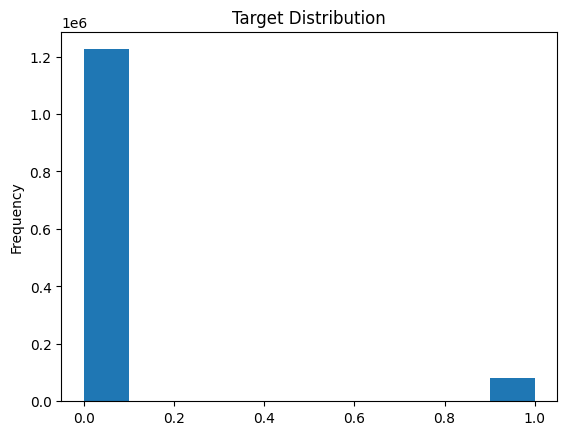

In [11]:
df.target.plot(kind='hist', title='Target Distribution')

## Task 4: Create tf.data.Datasets for Training and Evaluation

In [12]:
train_df , remaining = train_test_split(df, random_state=42, train_size=0.0075, stratify=df.target.values)
valid_df , _ = train_test_split(remaining, random_state=42, train_size=0.00075, stratify=remaining.target.values)

In [13]:
train_df.shape, valid_df.shape

((9795, 3), (972, 3))

In [14]:
with tf.device('/gpu:0'):
    train_data =tf.data.Dataset.from_tensor_slices((train_df['question_text'].values, train_df['target'].values))
    val_data =tf.data.Dataset.from_tensor_slices((valid_df['question_text'].values, valid_df['target'].values))
    
    for text, label in train_data.take(1):
        print(text)
        print(label)
        
    for text, label in val_data.take(1):
        print(text)
        print(label)

tf.Tensor(b'Why are unhealthy relationships so desirable?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'Can Austin Davis tell me how to get a job in the oil and gas industry?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


I0000 00:00:1759345252.472299   39144 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13717 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-10-02 00:30:54.016905: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-02 00:30:54.022585: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Task 5: Download a Pre-trained BERT Model from TensorFlow Hub

In [15]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

 # Label categories
 # maximum length of (token) input sequences
label_list = [0,1]
max_seq_len = 128
train_batch_size = 32

# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)


In [16]:
tokenizer.wordpiece_tokenizer.tokenize('hey, how are you doing?')

['hey', '##,', 'how', 'are', 'you', 'doing', '##?']

In [17]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hey, how are you doing?'))

[4931, 29623, 2129, 2024, 2017, 2725, 29632]

## Task 6: Tokenize and Preprocess Text for BERT

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1-SpKFELnEvBMBqO7h3iypo8q9uUUo96P' />
    <p style="text-align: center;color:gray">Figure 2: BERT Tokenizer</p>
</div>

We'll need to transform our data into a format BERT understands. This involves two steps. First, we create InputExamples using `classifier_data_lib`'s constructor `InputExample` provided in the BERT library.

In [18]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_len, tokenizer=tokenizer):
    example = classifier_data_lib.InputExample(guid=None,
                                              text_a = text.numpy(),
                                              text_b = None,
                                              label = label.numpy())
    feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)
    return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

You want to use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) runs in graph mode.

- Graph tensors do not have a value.
- In graph mode you can only use TensorFlow Ops and functions.

So you can't `.map` this function directly: You need to wrap it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function). The [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

## Task 7: Wrap a Python Function into a TensorFlow op for Eager Execution

In [19]:
def to_feature_map(text, label):
    input_ids, input_mask, segment_ids, label_ids = tf.py_function(to_feature, inp=[text, label],
                                                                  Tout=[tf.int32, tf.int32 ,tf.int32, tf.int32])
    input_ids.set_shape([max_seq_len])
    input_mask.set_shape([max_seq_len])
    segment_ids.set_shape([max_seq_len])
    label_ids.set_shape([])
    
    x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
    
    return (x, label_ids)

## Task 8: Create a TensorFlow Input Pipeline with `tf.data`


In [20]:
with tf.device('/gpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
               
    .shuffle(1000)
    .batch(32, drop_remainder=True)           
    .prefetch(tf.data.experimental.AUTOTUNE))
    
  # valid
  val_data = (val_data.map(to_feature_map,
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
               
    .batch(32, drop_remainder=True)           
    .prefetch(tf.data.experimental.AUTOTUNE))
  

The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):



In [21]:
# train data spec
train_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [22]:
# valid data spec
val_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

## Task 9: Add a Classification Head to the BERT Layer
<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 3: BERT Layer</p>
</div>

In [23]:
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32,
                                       name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32,
                                   name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32,
                                    name="input_type_ids")
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(drop)

  model = tf.keras.Model(
      inputs ={
          'input_word_ids': input_word_ids,
          'input_mask': input_mask,
          'input_type_ids': input_type_ids
      },
      outputs=output
  )
  return model

## Task 10: Fine-Tune BERT for Text Classification

In [24]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                              

In [25]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [26]:
# Train model
epochs=4
history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=epochs,
                    verbose=1)

Epoch 1/4


2025-10-02 00:31:20.547371: I external/local_xla/xla/service/service.cc:163] XLA service 0x7d5ffdbaf6e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-02 00:31:20.547409: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2025-10-02 00:31:20.583142: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-02 00:31:20.638427: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91301
I0000 00:00:1759345280.855188   39461 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


306/306 [==============================] - 142s 340ms/step - loss: 0.1691 - binary_accuracy: 0.9386 - val_loss: 0.1382 - val_binary_accuracy: 0.9552
Epoch 2/4
306/306 [==============================] - 103s 335ms/step - loss: 0.0976 - binary_accuracy: 0.9636 - val_loss: 0.1260 - val_binary_accuracy: 0.9542
Epoch 3/4
306/306 [==============================] - 103s 336ms/step - loss: 0.0478 - binary_accuracy: 0.9835 - val_loss: 0.1641 - val_binary_accuracy: 0.9531
Epoch 4/4
306/306 [==============================] - 104s 338ms/step - loss: 0.0236 - binary_accuracy: 0.9933 - val_loss: 0.1987 - val_binary_accuracy: 0.9552


## Task 11: Evaluate the BERT Text Classification Model

In [27]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [29]:
total = model.count_params()
print("Total params Million:", total/1000000)

Total params Million: 109.48301


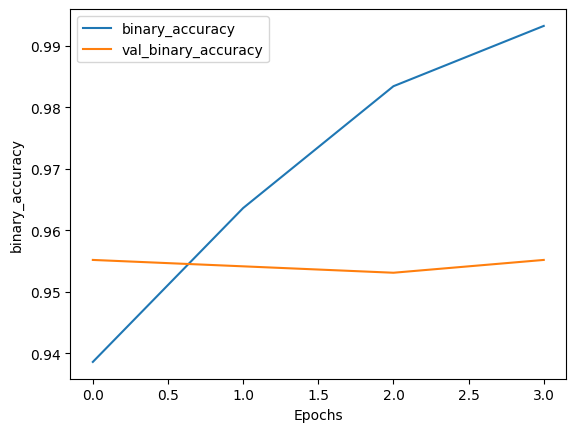

In [30]:
plot_graphs(history, "binary_accuracy")

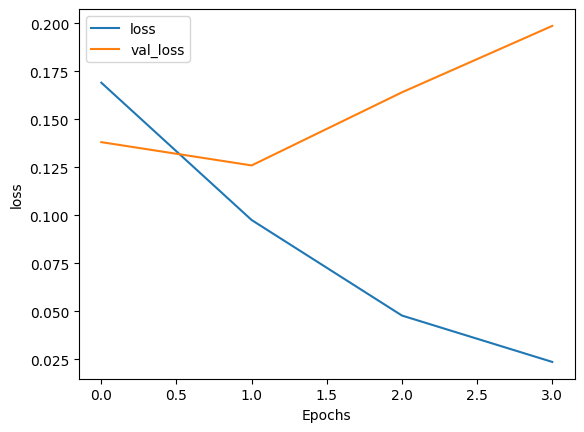

In [31]:
plot_graphs(history, "loss")